In [1]:
import numpy as np
import matplotlib
import pandas as pd
from sklearn.model_selection import train_test_split


dataset = pd.read_csv('/Users/eddie/OneDrive/Documents/Injury Dataset/2013-2022/2018-2022 Data Cleaned Trainable.csv')
data = pd.DataFrame(dataset.iloc[:,:22])
print(data.STATE)

X = pd.DataFrame(dataset.iloc[:,:22].values)
Y = pd.DataFrame(dataset.iloc[:,22:].values)
print(X)
print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(Y_train.shape)

0        1
1        1
2        1
3        1
4        1
        ..
44090    2
44091    2
44092    2
44093    2
44094    2
Name: STATE, Length: 44095, dtype: int64
       0   1   2   3   4   5   6   7   8   9   ...  12  13  14   15  16  17  \
0       1   1   1   1   0   1   3  55   1   1  ...   0   0   1    0   0   1   
1       1   1   1   1   0   1   0  16   1   1  ...   0   0   1    0   0   1   
2       1   1   1   1   3   0   3  41   1   1  ...   0   1   1    0   1   1   
3       1   1   2   2   3   0   0  21   2   1  ...   0   0   1    0   0   1   
4       1   1   2   1   3   0   1  66   1   1  ...   0   0   1  174   0   1   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ...  ..  ..   
44090   2   4   1   2   0   1   0  53   1   1  ...   1   0   1    0   0   1   
44091   2   4   1   2   0   1   2  27   1   1  ...   1   0   1    0   1   1   
44092   2   4   1   2   1   0   1  25   1   1  ...   1   1   1  155   0   1   
44093   2   4   1   2   1   0   1  21   2   1  .

In [2]:
features = pd.DataFrame(dataset.iloc[:,:32])
features = features.columns
print(features)

Index(['STATE', 'SEASON', 'DAY', 'HOUR', 'HARM_EV', 'MAN_COLL', 'BODY_TYP',
       'AGE', 'GENDER', 'PER_TYP', 'SEAT_POS', 'REST_USE', 'AIR_BAG',
       'DRINKING', 'ATST_TYP', 'ALC_RES', 'DRUGS', 'DSTATUS', 'ETHNICITY ',
       'RUR_URB', 'FUNC_SYS', 'IMPACT1', 'INJ_SEV'],
      dtype='object')


In [ ]:
from keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, GRU, LayerNormalization, MultiHeadAttention,TimeDistributed, Input, Flatten
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np


In [4]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 100.0, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 0.0, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "auto_class_weights": trial.suggest_categorical("auto_class_weights", [None, "Balanced", "SqrtBalanced"]),
        "verbose": 0,
        "random_seed": 42
    }

    model = CatBoostClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring="accuracy", n_jobs=-1)

    return np.mean(scores)

study = optuna.create_study(study_name = "catboost", direction="maximize", storage = "sqlite:///catboost.db")
study.optimize(objective, n_trials=50)

print("Best Accuracy: ", study.best_value)
print("Best Hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

c:\Users\eddie\anaconda3\envs\SSTP-Injury\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-30 22:49:10,259] A new study created in RDB with name: catboost
[I 2025-05-30 22:49:15,135] Trial 0 finished with value: 0.920314222074372 and parameters: {'iterations': 415, 'learning_rate': 0.011738801437157597, 'depth': 3, 'l2_leaf_reg': 0.16959126050742923, 'border_count': 98, 'random_strength': 5.2261227301297755, 'bagging_temperature': 0.08791730361286931, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.920314222074372.
[I 2025-05-30 22:49:19,073] Trial 1 finished with value: 0.9256719635645423 and parameters: {'iterations': 315, 'learning_rate': 0.1423607819183434, 'depth': 5, 'l2_leaf_reg': 11.891940716746214, 'border_count': 183, 'random_strength': 5.702010116930066, 'bagging_temperature':

Best Accuracy:  0.9266073939616006
Best Hyperparameters:
  iterations: 519
  learning_rate: 0.0214886155779932
  depth: 7
  l2_leaf_reg: 0.0041102106843915655
  border_count: 188
  random_strength: 1.1024738816675557
  bagging_temperature: 0.4400386588257677
  auto_class_weights: None


In [10]:
model = CatBoostClassifier(
    iterations = 519,
    learning_rate = 0.0214886155779932,
    depth = 7,
    l2_leaf_reg = 0.0041102106843915655,
    border_count = 188,
    random_strength = 1.1024738816675557,
    bagging_temperature = 0.4400386588257677,
    auto_class_weights = None
)
model.fit(X_train, Y_train)

0:	learn: 1.0639961	total: 10ms	remaining: 5.19s
1:	learn: 1.0310320	total: 17.5ms	remaining: 4.53s
2:	learn: 1.0000101	total: 26ms	remaining: 4.48s
3:	learn: 0.9710013	total: 33.5ms	remaining: 4.31s
4:	learn: 0.9430014	total: 41.2ms	remaining: 4.24s
5:	learn: 0.9173230	total: 48.6ms	remaining: 4.16s
6:	learn: 0.8926254	total: 58ms	remaining: 4.24s
7:	learn: 0.8697379	total: 61.1ms	remaining: 3.9s
8:	learn: 0.8469561	total: 67.8ms	remaining: 3.84s
9:	learn: 0.8255461	total: 75.8ms	remaining: 3.86s
10:	learn: 0.8054946	total: 83.7ms	remaining: 3.87s
11:	learn: 0.7863809	total: 87ms	remaining: 3.68s
12:	learn: 0.7678225	total: 94.2ms	remaining: 3.67s
13:	learn: 0.7496066	total: 101ms	remaining: 3.64s
14:	learn: 0.7324258	total: 108ms	remaining: 3.63s
15:	learn: 0.7156027	total: 116ms	remaining: 3.63s
16:	learn: 0.6998051	total: 123ms	remaining: 3.64s
17:	learn: 0.6841728	total: 130ms	remaining: 3.62s
18:	learn: 0.6692031	total: 138ms	remaining: 3.64s
19:	learn: 0.6548114	total: 146ms	rem

In [11]:
res = model.predict(X_test)
print(res)
print(Y_test)

[[0]
 [1]
 [2]
 ...
 [2]
 [2]
 [2]]
       0
42222  0
29490  1
7168   2
35124  1
29931  2
...   ..
41573  2
22780  0
42708  2
28199  2
22171  2

[8819 rows x 1 columns]


In [12]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test,res)
print(accuracy)
from sklearn.metrics import classification_report
print(classification_report(Y_test,res,digits=6))

0.9223267944211362
              precision    recall  f1-score   support

           0   0.790031  0.784653  0.787333      1616
           1   0.792980  0.798204  0.795583      1670
           2   1.000000  1.000000  1.000000      5533

    accuracy                       0.922327      8819
   macro avg   0.861004  0.860952  0.860972      8819
weighted avg   0.922323  0.922327  0.922322      8819



PermutationExplainer explainer: 8820it [31:06,  4.69it/s]                          
C:\Users\eddie\AppData\Local\Temp\ipykernel_8728\1552002207.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test,feature_names = features,plot_size=(20,15),plot_type="bar",show=False)


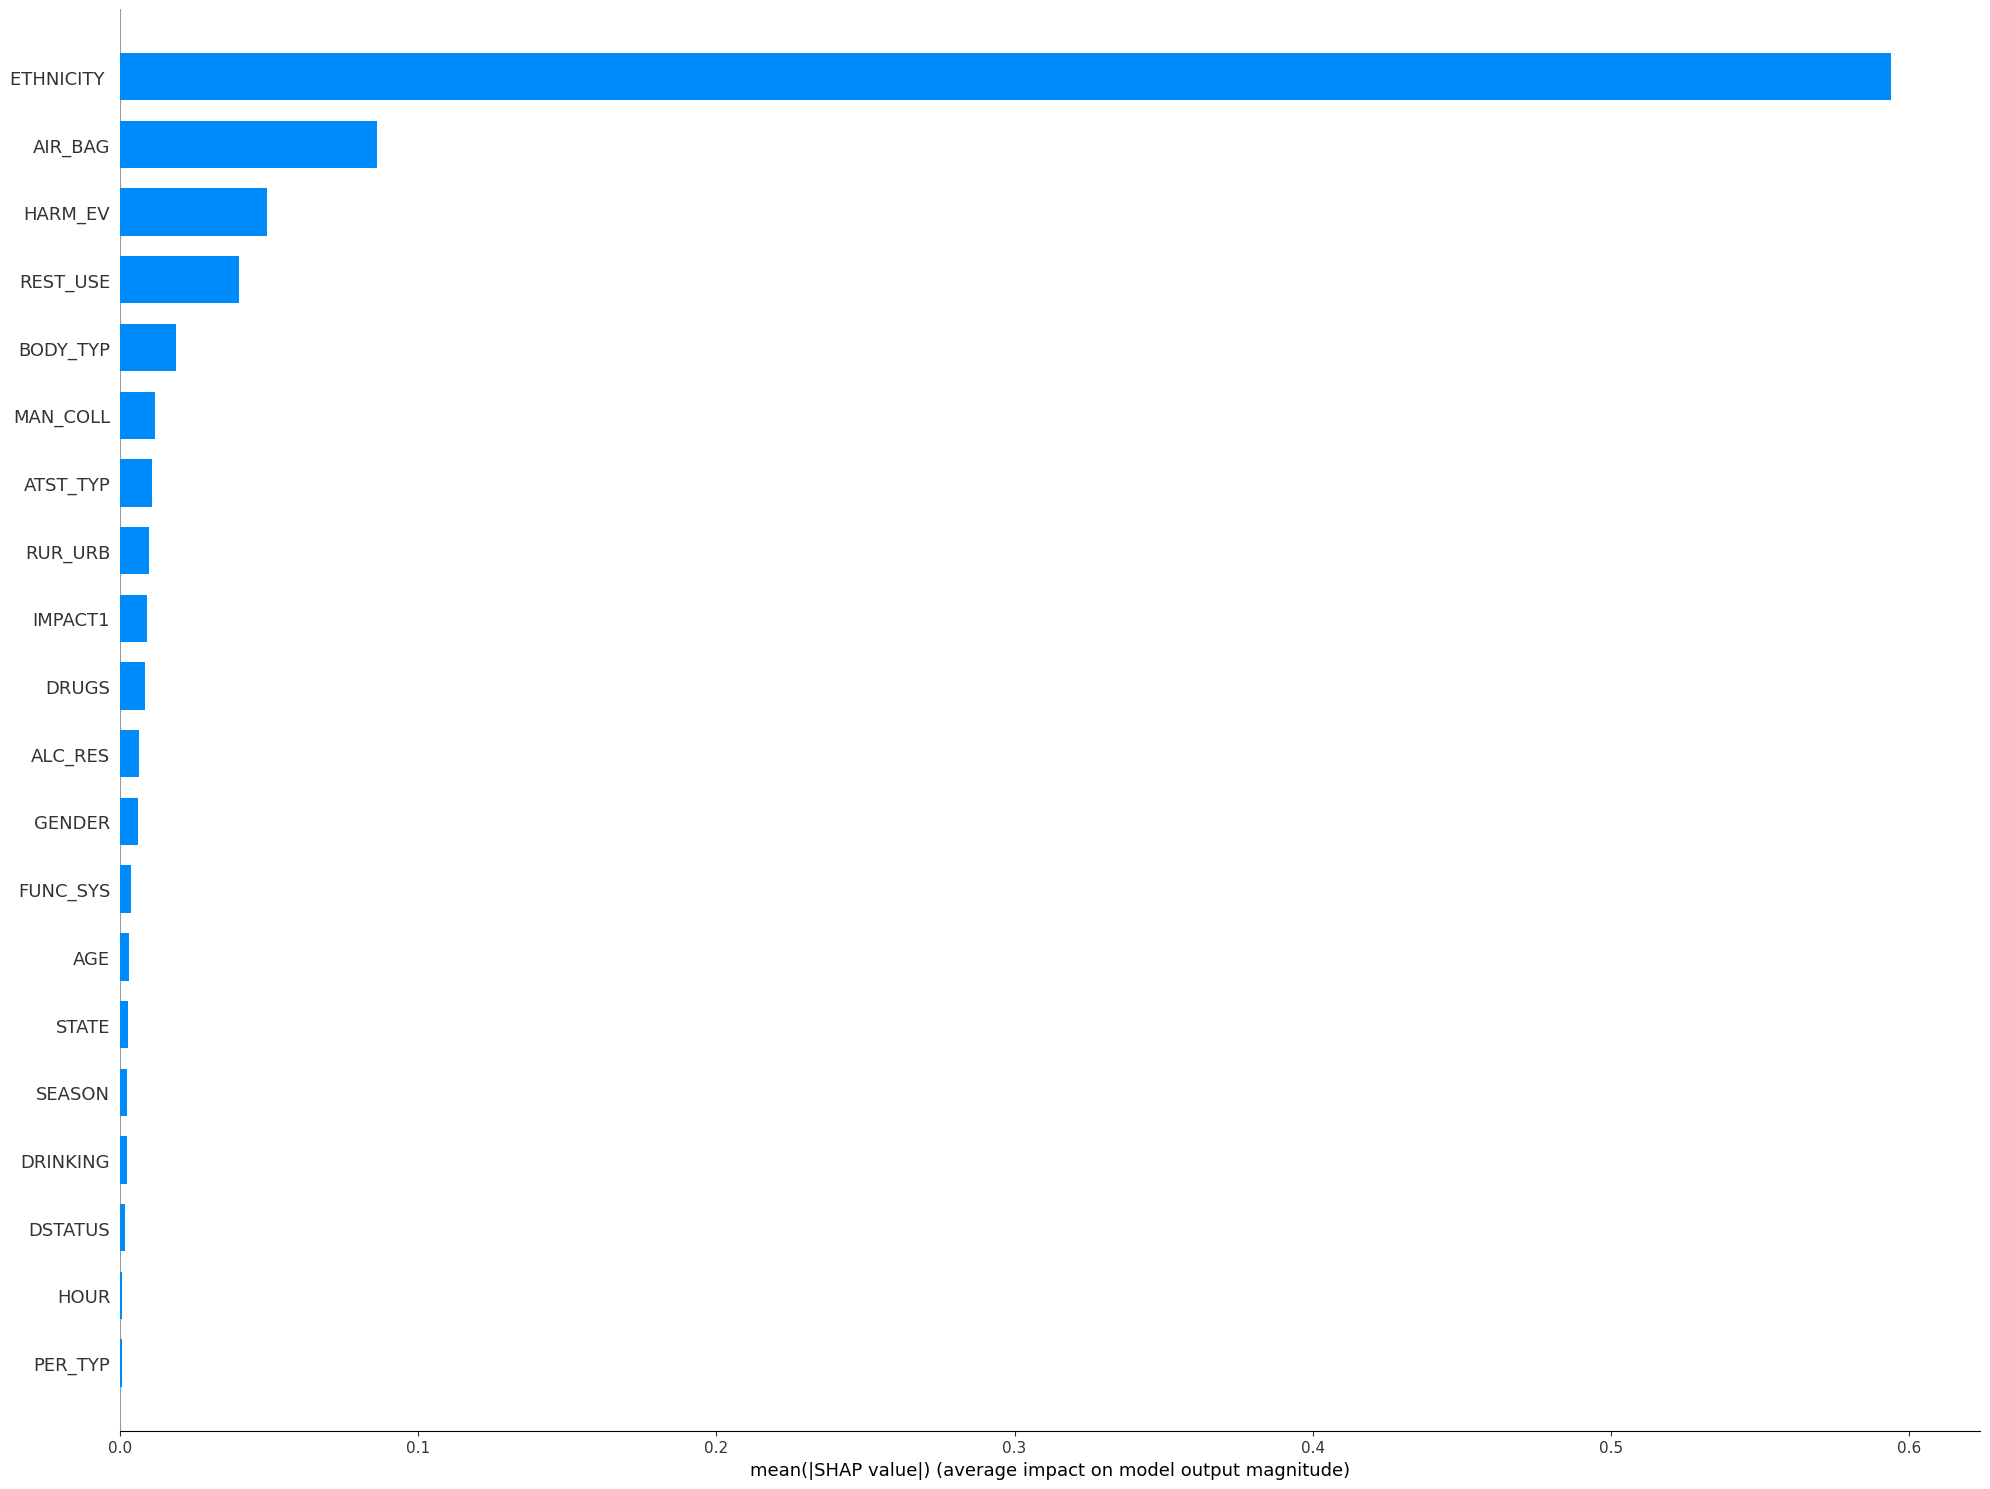

In [13]:
import shap 
explainer = shap.Explainer(model.predict,X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test,feature_names = features,plot_size=(20,15),plot_type="bar",show=False)

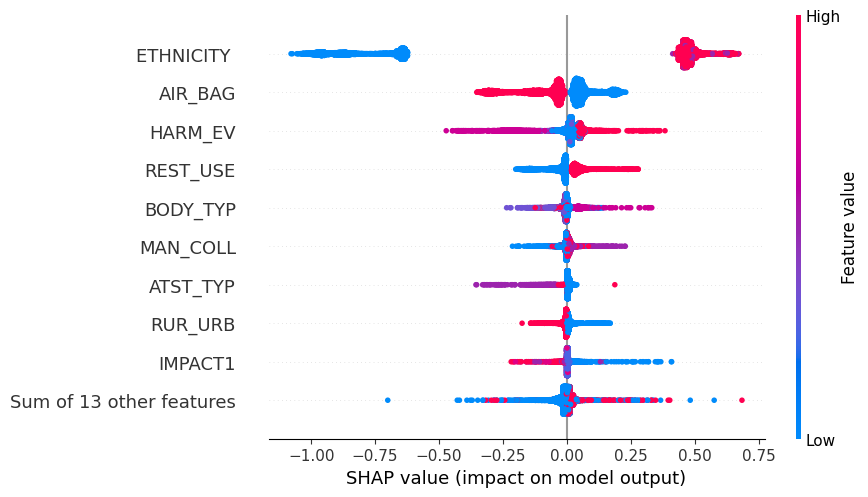

In [14]:
explanation = shap.Explanation(
    values=shap_values, 
    feature_names=features
)
shap.plots.beeswarm(explanation)

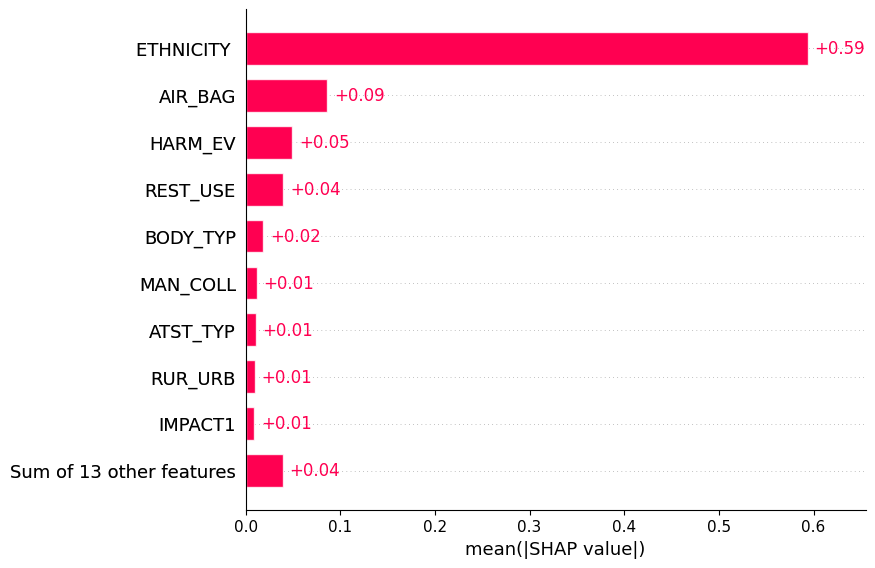

In [15]:
shap.plots.bar(explanation)

In [16]:
import matplotlib.pyplot as plt
import os

indices = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
for i in indices:
    shap.plots.waterfall(explanation[i], show=False)
    plt.savefig(os.path.join("shap/catboost/waterfall", f"waterfall_{i}.png"), dpi = 300,bbox_inches="tight")
    plt.close()


In [17]:
import matplotlib.pyplot as plt
import os

indices = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
for i in indices:
    # shap.plots.waterfall(explanation[i], show=False)
    # shap.initjs()
    shap.force_plot(shap_values[i],feature_names=['STATE', 'SEASON', 'DAY', 'HOUR', 'HARM_EV', 'MAN_COLL', 'BODY_TYP', 'AGE', 'GENDER', 'PER_TYP', 'SEAT_POS', 'REST_USE', 'AIR_BAG', 'DRINKING', 'ATST_TYP', 'ALC_RES', 'DRUGS', 'DSTATUS', 'ETHNICITY ', 'RUR_URB', 'FUNC_SYS', 'IMPACT1'], matplotlib=True, show=False)
    plt.savefig(os.path.join("shap/catboost/force/", f"force_{i}.png"), dpi = 300,bbox_inches="tight")
    # shap.save_html(os.path.join("shap/adaboost/force/", f"force_{i}.png"), force_plot)
    plt.close()


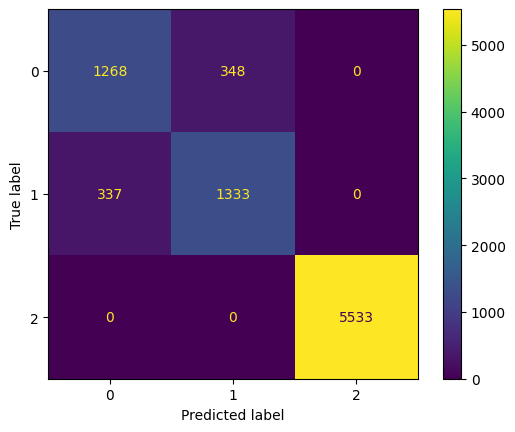

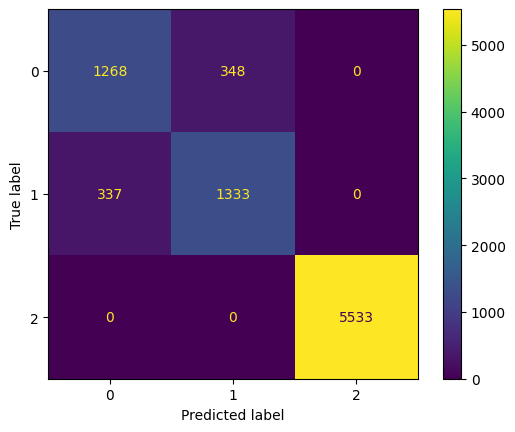

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusionmatrix = confusion_matrix(Y_test, res)
cm_display = ConfusionMatrixDisplay(confusionmatrix)
cm_display.plot()
plt.show()